In [26]:
#Importing necessary libraries

from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.pipeline import Pipeline


Data Loading and Initial Exploration

In [27]:
import findspark
findspark.init()

#Initialize Spark Session
spark = SparkSession.builder.appName("FlightDelayPrediction").config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g").getOrCreate()

In [28]:
spark.sparkContext.setLogLevel("ERROR")


In [29]:
#Load the dataset
df = spark.read.csv("../Dataset/Combined_Flights_2022.csv",header=True,inferSchema=True)

In [30]:
#Partitioning the dataset
df = df.repartition(10)

In [31]:
#Display schema and first 10 rows
df.printSchema()
df.show(20)

root
 |-- FlightDate: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+--------------------+---------+-------------+--------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|

In [32]:
#Count the total number of rows
row_count = df.count()
print("Total rows:", row_count)

Total rows: 4078318


Data Cleaning and Transformation

In [33]:
df.count()

4078318

In [34]:
# Check for null values
null_counts = df.select([count(when(col(c).isNull() | (col(c).cast("string") == ""), c)).alias(c) if df.schema[c].dataType != "boolean" else count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|

In [35]:
df = df.fillna(0)

In [36]:
# Remove duplicates
df = df.dropDuplicates()

In [37]:
df.show()

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-----------------+---------+-------------+--------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|Dep

Data Analysis Using Spark SQL

In [38]:
# Register the cleaned DataFrame as a SQL temporary view

df.createOrReplaceTempView("flight_data")

In [39]:
# Aggregation: Calculate summary statistics for delays
spark.sql("""
    SELECT 
        AVG(DepDelayMinutes) AS avg_dep_delay,
        STDDEV(DepDelayMinutes) AS stddev_dep_delay,
        AVG(ArrDelayMinutes) AS avg_arr_delay,
        STDDEV(ArrDelayMinutes) AS stddev_arr_delay
    FROM flight_data
""").show()

+------------------+-----------------+-----------------+-----------------+
|     avg_dep_delay| stddev_dep_delay|    avg_arr_delay| stddev_arr_delay|
+------------------+-----------------+-----------------+-----------------+
|15.541772367922267|51.60764838748215|15.26680631574095|51.20398526781139|
+------------------+-----------------+-----------------+-----------------+



In [40]:
# Grouping: Average departure delay by airline

spark.sql("""
    SELECT 
        Airline, 
        AVG(DepDelayMinutes) AS avg_dep_delay
    FROM flight_data
    GROUP BY Airline
    ORDER BY avg_dep_delay DESC
""").show()

+--------------------+------------------+
|             Airline|     avg_dep_delay|
+--------------------+------------------+
|     JetBlue Airways|27.719100980273353|
|Frontier Airlines...|22.901174948299964|
|       Allegiant Air| 21.80333043099695|
|GoJet Airlines, L...| 18.87784899261346|
|  Mesa Airlines Inc.| 18.08689490357361|
|    Spirit Air Lines|17.811993065444863|
|American Airlines...|17.066526465209407|
|         Comair Inc.|16.283013452650792|
|United Air Lines ...| 16.02247669803897|
|Commutair Aka Cha...|15.793945950819303|
|Southwest Airline...|15.565945964408922|
|SkyWest Airlines ...| 14.65574956840522|
|   Republic Airlines| 14.06109732617078|
|Delta Air Lines Inc.| 13.56800829502806|
|   Endeavor Air Inc.|12.755356742203276|
|Air Wisconsin Air...|12.669503722084368|
|Capital Cargo Int...|11.728831847350786|
|           Envoy Air| 9.942702874805981|
|Alaska Airlines Inc.| 9.868998532931819|
|Hawaiian Airlines...| 8.817232066710888|
+--------------------+------------

In [41]:

# Time-based analysis: Delay trends by month
spark.sql("""
    SELECT 
        Year, Month, 
        AVG(DepDelayMinutes) AS avg_dep_delay,
        AVG(ArrDelayMinutes) AS avg_arr_delay
    FROM flight_data
    GROUP BY Year, Month
    ORDER BY Year, Month
""").show()

+----+-----+------------------+------------------+
|Year|Month|     avg_dep_delay|     avg_arr_delay|
+----+-----+------------------+------------------+
|2022|    1|13.705046856956347|13.416756395269426|
|2022|    2|13.803124134535496|13.557080268947903|
|2022|    3|15.101357735774933|15.008263595138025|
|2022|    4|  15.6919798721329|15.542745868445088|
|2022|    5|14.960195704453106|             14.74|
|2022|    6|17.780065674844742| 17.25033842310612|
|2022|    7|17.344394705796798|16.960290243863025|
+----+-----+------------------+------------------+



Insights or patterns observed

In [42]:
# Delay patterns by month
spark.sql("""
    SELECT 
        Year, Month, 
        AVG(DepDelayMinutes) AS avg_dep_delay,
        AVG(ArrDelayMinutes) AS avg_arr_delay
    FROM flight_data
    GROUP BY Year, Month
    ORDER BY Year, Month
""").show()

+----+-----+------------------+------------------+
|Year|Month|     avg_dep_delay|     avg_arr_delay|
+----+-----+------------------+------------------+
|2022|    1|13.705046856956347|13.416756395269426|
|2022|    2|13.803124134535496|13.557080268947903|
|2022|    3|15.101357735774933|15.008263595138025|
|2022|    4|  15.6919798721329|15.542745868445088|
|2022|    5|14.960195704453106|             14.74|
|2022|    6|17.780065674844742| 17.25033842310612|
|2022|    7|17.344394705796798|16.960290243863025|
+----+-----+------------------+------------------+



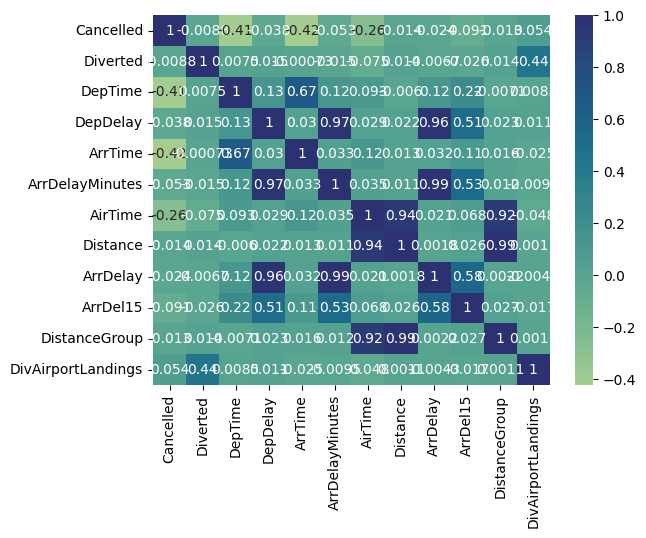

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns for correlation analysis
cols = ["Cancelled", "Diverted","DepTime", "DepDelay", "ArrTime", 
        "ArrDelayMinutes", "AirTime","Distance","ArrDelay", "ArrDel15", "DistanceGroup", "DivAirportLandings"]

# Compute the correlation matrix for the selected columns
corr_matrix = df.select(cols).toPandas().corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="crest")

# Show the plot
plt.show()

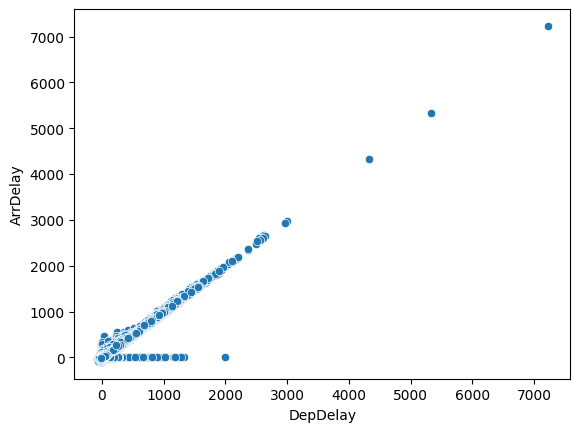

In [44]:

# Select departure delay and arrival delay columns
delay_df = df.select("DepDelay", "ArrDelay").toPandas()

# Create scatterplot using Seaborn
sns.scatterplot(x="DepDelay", y="ArrDelay", data=delay_df)

# Show plot
plt.show()

Machine Learning Model(Regression/Classification)

Split the dataset into training and testing sets.
• Choose the appropriate ML problem based on the dataset:
o Regression: Predict a continuous label (e.g., predicting taxi fare, house prices).
o Classification: Predict a categorical label (e.g., predicting product rating as high/low,
predicting whether a flight will be delayed).
• Build a pipeline using PySpark MLlib that includes:
o Feature engineering: Extract or transform relevant features.
o VectorAssembler: Combine all features into a single vector.
o Model selection: Use an appropriate algorithm (e.g., LinearRegression,
LogisticRegression, RandomForestClassifier).
o Model evaluation: Evaluate the model using metrics such as RMSE for regression or
accuracy/F1-score for classification.

Model Tuning and Evaluation

In [45]:
from pyspark.sql.functions import col

# Convert boolean columns to integers for modeling
df = df.withColumn("Cancelled", col("Cancelled").cast("Integer")) \
       .withColumn("Diverted", col("Diverted").cast("Integer"))

from pyspark.sql.functions import when

df = df.withColumn("Delayed", when(col("ArrDelayMinutes") > 15, 1).otherwise(0))



In [46]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder


# Index categorical features first
airline_indexer = StringIndexer(inputCol="Airline", outputCol="AirlineIndex")
origin_indexer = StringIndexer(inputCol="Origin", outputCol="OriginIndex")

# Apply OneHotEncoder to indexed columns
airline_encoder = OneHotEncoder(inputCol="AirlineIndex", outputCol="AirlineVec")
origin_encoder = OneHotEncoder(inputCol="OriginIndex", outputCol="OriginVec")

# Assemble features including the encoded vectors
feature_columns = ['Distance', 'DepDelayMinutes', 'Cancelled', 'Diverted', 'AirlineVec', 'OriginVec', 'Month', 'DayOfWeek']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

In [47]:
train_data, test_data= df.randomSplit([0.8, 0.2], seed=123)

Logistic Regression

In [48]:
from pyspark.ml.classification import LogisticRegression

# Define the Logistic Regression model
logistic_regression = LogisticRegression(featuresCol='features', labelCol='Delayed', maxIter=50, regParam=0.1)


In [49]:
# Set up the pipeline with all the stages in the correct sequence
pipeline_lr = Pipeline(stages=[airline_indexer, origin_indexer, airline_encoder, origin_encoder, assembler, logistic_regression])


In [50]:
# Train the pipeline model
pipeline_model_lr = pipeline_lr.fit(train_data)

In [51]:
# Make predictions on the test set
predictions_lr = pipeline_model_lr.transform(test_data)

# Show some predictions
predictions_lr.select("features", "Delayed", "prediction", "probability").show(5)


+--------------------+-------+----------+--------------------+
|            features|Delayed|prediction|         probability|
+--------------------+-------+----------+--------------------+
|(400,[0,1,3,23,52...|      0|       0.0|[0.93975243271447...|
|(400,[0,2,23,25,3...|      0|       0.0|[0.93567072353609...|
|(400,[0,14,89,398...|      0|       0.0|[0.85370246588173...|
|(400,[0,1,14,89,3...|      1|       1.0|[0.19916773567238...|
|(400,[0,1,14,32,3...|      0|       0.0|[0.82650558026549...|
+--------------------+-------+----------+--------------------+
only showing top 5 rows



In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate model accuracy
evaluator_lr = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator_lr.evaluate(predictions_lr)
print(f"Accuracy: {accuracy_lr:.2f}")

# Evaluate F1 Score
evaluator_f1_lr = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="f1")
f1_score_lr = evaluator_f1_lr.evaluate(predictions_lr)
print(f"F1 Score: {f1_score_lr:.2f}")


Accuracy: 0.84


F1 Score: 0.79


Model Tuning and Evaluation

In [53]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

paramGrid = ParamGridBuilder() \
    .addGrid(logistic_regression.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(logistic_regression.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


In [54]:
evaluator_lr1 = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="accuracy")
accuracy_lr1 = evaluator_lr1.evaluate(predictions_lr)
print(f"Accuracy: {accuracy_lr:.2f}")

# Set up CrossValidator
crossval = CrossValidator(estimator=pipeline_lr,  #  pipeline object
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_lr1,
                          numFolds=3) 

Accuracy: 0.84


In [55]:
# Train the model using cross-validation
cv_model = crossval.fit(train_data)

In [56]:
# Make predictions on the test set using the best model
predictions = cv_model.transform(test_data)  # 'test_df' is your testing DataFrame


In [57]:
# Evaluate accuracy and F1 score
accuracy_evaluator_cv = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="accuracy")
accuracy_cv = accuracy_evaluator_cv.evaluate(predictions)
print(f"Accuracy of the tuned model: {accuracy_cv:.2f}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score of the tuned model: {f1_score:.2f}")


Accuracy of the tuned model: 0.93


F1 Score of the tuned model: 0.92


In [58]:
auc_evaluator = BinaryClassificationEvaluator(labelCol="Delayed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)
print(f"Area Under ROC: {auc:.2f}")

Area Under ROC: 0.93


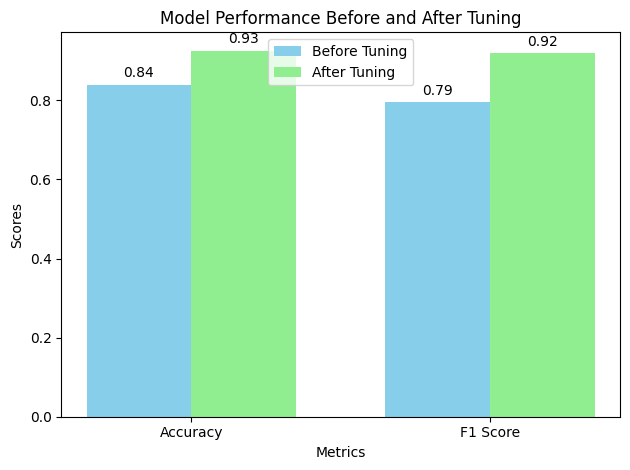

In [61]:
# Evaluator for model performance (multiclass)
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy before tuning
accuracy_before = accuracy_evaluator.evaluate(predictions_lr)

# Calculate accuracy after tuning
accuracy_after = accuracy_evaluator.evaluate(predictions)

# Evaluate F1 Score for a more comprehensive metric
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="f1")

# Calculate F1 score before tuning
f1_before = f1_evaluator.evaluate(predictions_lr)

# Calculate F1 score after tuning
f1_after = f1_evaluator.evaluate(predictions)

# Visualization of accuracy and F1 score before and after tuning
metrics = ['Accuracy', 'F1 Score']
values_before = [accuracy_before, f1_before]
values_after = [accuracy_after, f1_after]
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_before, width, label='Before Tuning', color='skyblue')
rects2 = ax.bar(x + width/2, values_after, width, label='After Tuning', color='lightgreen')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Before and After Tuning')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add labels to bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# Show plot
plt.show()
